<h1 align="center">Walmart Demand Forecasting</h1>

<h4 align="center">Domain: Demand Forecasting</h4>

**Dataset Name**: Walmart Dataset

**Description**: This dataset provides historical sales data for 45 Walmart stores located in different regions. The dataset covers 2010-02-05 to 2012-11-01 and includes various economic factors and holiday information that might affect sales. Walmart seeks to improve sales and demand prediction accuracy using machine learning. Key challenges include modeling the impact of promotional markdown events preceding major holidays like the Super Bowl, Labor Day, Thanksgiving, and Christmas, which significantly influence sales. The dataset aims to enhance forecasting capabilities amidst fluctuating demand and economic conditions.

**Source**: The dataset is sourced from Kaggle [link](https://www.kaggle.com/datasets/yasserh/walmart-dataset/data)

**Objective**: The goal of this analysis is to understand the key factors that influence sales at Walmart stores and to develop a model that accurately predicts future sales. This model can help Walmart optimize inventory management, staffing, and marketing strategies.

## Explanation of Each Column:

| Column Name       | Description                                              | Data Type | Notes                               |
|-------------------|----------------------------------------------------------|-----------|-------------------------------------|
| Store             | Unique identifier for each store                         | Integer | Distinguishes sales data across different Walmart stores |
| Date              | Date of the sales data                                   | Object to be converted to datetime64[ns]  | Indicates the week of sales |
| Weekly_Sales      | Sales recorded for the given store for that week | Float | Target variable for the predictive model |
| Holiday_Flag         | Indicator for whether the week includes a major holiday  | Integer | Affects sales patterns 1=Holiday week 0=Non-hoiday week|
| Temperature       | Average temperature for the region during that week      | Float | Provides insights into how weather conditions impact sales |
| Fuel_Price        | Cost of fuel in the region for that week                 | Float | Can influence consumer spending behavior |
| CPI               | Consumer Price Index                                     | Float | Represents the relative cost of consumer goods and services, impacting purchasing power |
| Unemployment      | Unemployment rate in the region for that week            | Float | Higher unemployment rates might negatively affect sales |
| Year          | Year of the sales data                                   | Integer   | Extracted from the Date column after conversion |
| Month         | Month of the sales data                                  | Integer   | Extracted from the Date column after conversion |
| Day           | Day of the sales data                                    | Integer   | Extracted from the Date column after conversion |
| WeekOfYear    | ISO week date system: week number of the sales data                        | Integer   | Extracted from the Date column after conversion |

###Visual inspection of the data

In [92]:
import pandas as pd
import numpy as np

# Create a DataFrame
df = pd.read_csv('Walmart.csv')

print("First 5 rows of the DataFrame:")
print(df.head())

# Add blank lines for readability
print()
print()

# Information about DataFrame size
num_rows, num_columns = df.shape
print(f"The DataFrame has {num_rows} rows and {num_columns} columns.")

First 5 rows of the DataFrame:
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


The DataFrame has 6435 rows and 8 columns.


###Exploratory Data Analysis (EDA)

In [93]:
from datetime import datetime

# Dataframe Information
print("Dataframe Information:")
print(df.info())
print()

# Date is 2010-02-05 object-we need to convert it to datetime format in order to extract later
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y') # converts object(string) format to datetime format
df['Year'] = df.Date.dt.year
df['Month'] = df.Date.dt.month
df['Day'] = df.Date.dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Dataframe Information check after date conversion
print("Dataframe Information with Date converted:")
print(df.info())

# Check for missing values
missing_values = df.isnull().sum().sum()  # Total number of missing values in the DataFrame
print()
if missing_values == 0:
    print("There are no missing values in the DataFrame.")
else:
    print(f"There are {missing_values} missing values in the DataFrame.")
print()

#Check for duplicates
duplicate_rows = df[df.duplicated()]
if not duplicate_rows.empty:
    print("Duplicate rows found in the DataFrame:")
    print(duplicate_rows)
else:
    print("No duplicate rows found in the DataFrame.")
print()

# Check for unique values (Store expected to have unique identifier; Year, Month, day, WeekOfYear derived from Date are used for
# time-series analysis, trends, patterns, etc so need to ensur uniqueness here. Other columns are continuous or categorical that do not
# require unique check)
columns_to_check_unique = ['Store', 'Year', 'Month', 'Day', 'WeekOfYear']
for col in columns_to_check_unique:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}':")
    print(unique_values)
    print()

# Descriptive statistics
print("Descriptive Statistics:")
print(df.describe())
print()

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Check for outliers - numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
# Using IQR method for each numerical column
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    if not outliers.empty:
        print(f"Column '{col}' has {len(outliers)} outliers according to IQR method.")
print()


Dataframe Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None

Dataframe Information with Date converted:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  64

#####**Descriptive Statistics summary:**
---
Store has a mean of 23 suggesting the dataset covers a range of stores with each contributing around the same on average. It is a distribution that indicates the sales data is fairly represented across the 45 stores that are included.

Outcome variable: Weekly_Sales has a mean ~1,046,965 dollars with a standard deviation of ~$564,366. The range is 209,986-3,818,686 suggesting a broad range of variability/weekly sales. The diversity here across the different weeks may be influenced by other factors.

Holiday_Flag shows a mean of ~7% of sales are conducted on a holiday with a low .255 standard deviation which implies it is consistent but somewhat of a minor impact on sales compared to the non-holiday weeks.

Temperature and Economic factors: The average temperature is ~ 60.66 degrees and may help in understanding seasonal variations in consumer behiavior and/or sales patterns. Fuel_Price has a mean of ~3.36, CPI is ~171.58, Unemployment ~8.

Date Components: Month, Day and WeekOfYear suggests the average peak sales are around mid June, the 25th week of the year.


#####**Outliers**
---

Column 'Weekly_Sales' has 34 outliers according to IQR method.<br>
Column 'Holiday_Flag' has 450 outliers according to IQR method.<br>
Column 'Temperature' has 3 outliers according to IQR method.<br>
Column 'Unemployment' has 481 outliers according to IQR method.<br>
We will look to reason and plot:


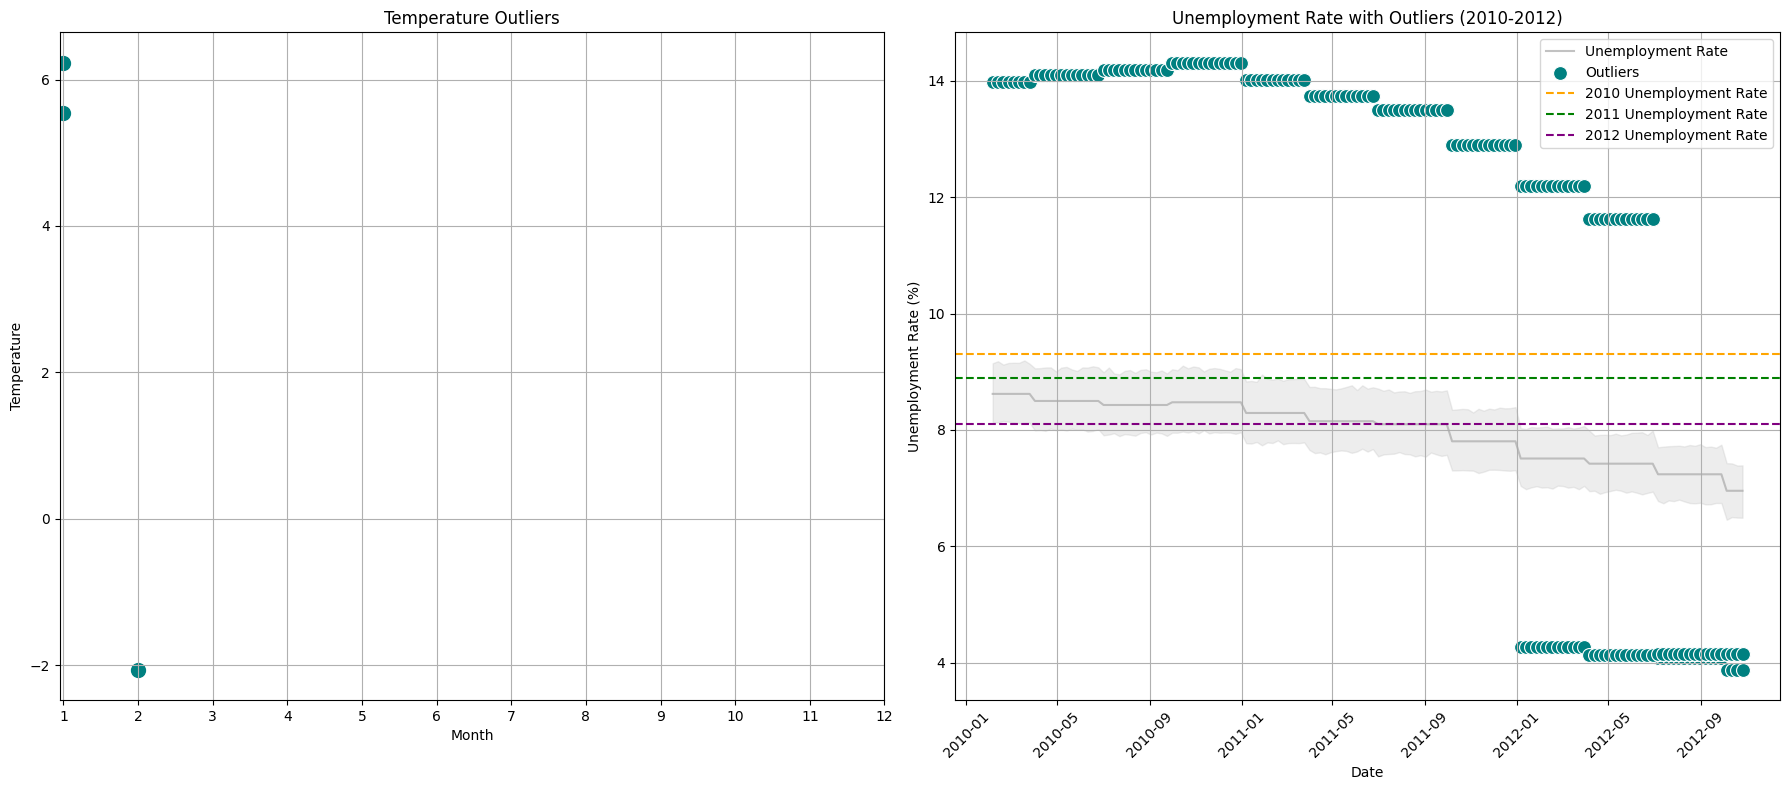

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter outliers in the Temperature column using IQR method
Q1_temp = df['Temperature'].quantile(0.25)
Q3_temp = df['Temperature'].quantile(0.75)
IQR_temp = Q3_temp - Q1_temp
lower_bound_temp = Q1_temp - 1.5 * IQR_temp
upper_bound_temp = Q3_temp + 1.5 * IQR_temp

temperature_outliers = df[(df['Temperature'] < lower_bound_temp) | (df['Temperature'] > upper_bound_temp)]

# Filter outliers in the Unemployment column using IQR method
Q1_unemployment = df['Unemployment'].quantile(0.25)
Q3_unemployment = df['Unemployment'].quantile(0.75)
IQR_unemployment = Q3_unemployment - Q1_unemployment
lower_bound_unemployment = Q1_unemployment - 1.5 * IQR_unemployment
upper_bound_unemployment = Q3_unemployment + 1.5 * IQR_unemployment

unemployment_outliers = df[(df['Unemployment'] < lower_bound_unemployment) | (df['Unemployment'] > upper_bound_unemployment)]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plotting the temperature outliers
ax1.scatter(temperature_outliers['Month'], temperature_outliers['Temperature'], color='#008080', marker='o', s=100)  # Teal color
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature')
ax1.set_title('Temperature Outliers')
ax1.grid(True)
ax1.set_xticks(range(1, 13))

# Plotting the unemployment outliers
sns.lineplot(data=df, x='Date', y='Unemployment', label='Unemployment Rate', color='#A9A9A9', alpha=0.7, ax=ax2)  # Grey color
sns.scatterplot(data=unemployment_outliers, x='Date', y='Unemployment', color='#008080', label='Outliers', s=100, ax=ax2)  # Pale lavender color

# Mark significant periods based on historical data
ax2.axhline(y=9.3, color='orange', linestyle='--', label='2010 Unemployment Rate')
ax2.axhline(y=8.9, color='green', linestyle='--', label='2011 Unemployment Rate')
ax2.axhline(y=8.1, color='purple', linestyle='--', label='2012 Unemployment Rate')

ax2.set_xlabel('Date')
ax2.set_ylabel('Unemployment Rate (%)')
ax2.set_title('Unemployment Rate with Outliers (2010-2012)')
ax2.legend()
ax2.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

plt.tight_layout()
plt.show()


#####**Outliers**
---

Column 'Temperature' has 3 outliers we will keep. It is reasonable that some months are colder year to year and these 3 outliers are showing up in January and February.

Column 'Unemployment' has 481 outliers. According to [statista.com](https://www.statista.com/statistics/193290/unemployment-rate-in-the-usa-since-1990/) there was high unemployment rate during the time of this dataset of:
2010 9.3%, 2011 8.9%, 2012 8.1%. Given that the period (2010-02-05 to 2012-11-01) includes years with high unemployment rates, a large number of outliers might reflect genuine economic conditions rather than errors. We will keep the outliers to preserve data integrity and complexity of the dataset as they may provide insights into unusual or significant economic events or trends needed for analysis.


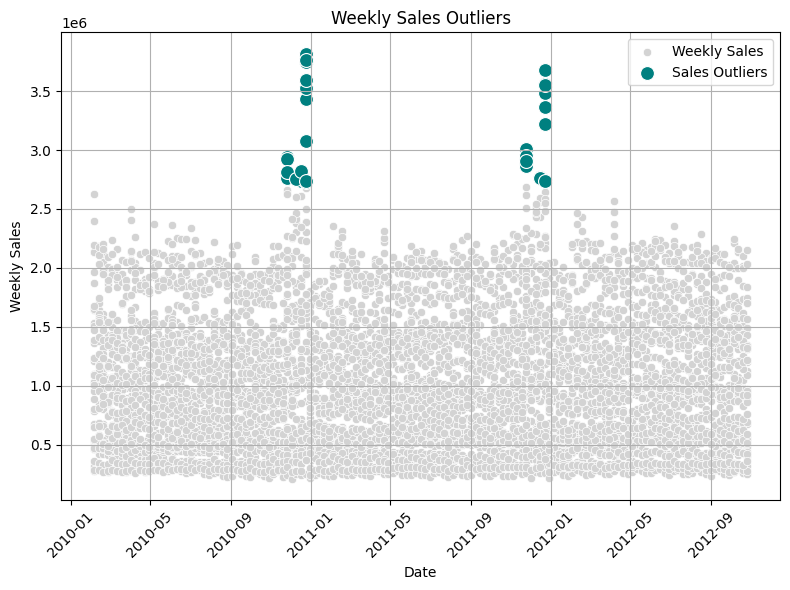

In [95]:
# 'Weekly_Sales' column
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Defining the upper bound for outliers based on IQR
upper_bound_sales = Q3 + 1.5 * IQR

# Filtering outliers in weekly sales
sales_outliers = df[df['Weekly_Sales'] > upper_bound_sales]

# Plotting only the Weekly Sales outliers in teal
plt.figure(figsize=(8, 6))

# Plot all Weekly Sales data
sns.scatterplot(x='Date', y='Weekly_Sales', data=df, color='lightgray', label='Weekly Sales')

# Plotting outliers in teal
sns.scatterplot(x='Date', y='Weekly_Sales', data=sales_outliers, color='teal', label='Sales Outliers', s=100)

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Outliers')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#####**Outliers**
---

Column 'Weekly_Sales' has 34 outliers that appear to be tied to the Christmas shopping season in December suggesting this is when sales spike and are to be expected. For this reason, we will keep the outliers.

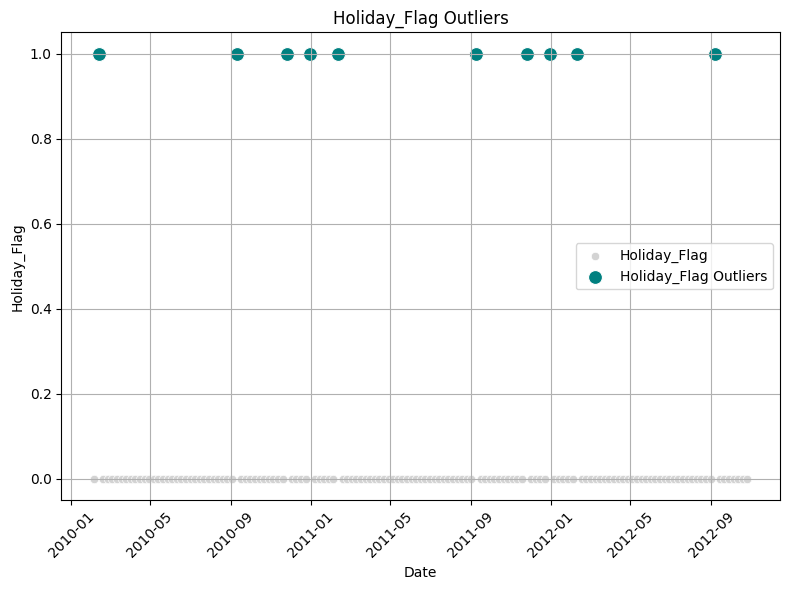

Number of outliers in Holiday_Flag: 450
Percentage of outliers in Holiday_Flag: 6.99%


In [96]:
# Calculate outliers based on IQR method for 'Holiday_Flag'
Q1 = df['Holiday_Flag'].quantile(0.25)
Q3 = df['Holiday_Flag'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers for 'Holiday_Flag'
holiday_flag_outliers = df[(df['Holiday_Flag'] < (Q1 - 1.5 * IQR)) | (df['Holiday_Flag'] > (Q3 + 1.5 * IQR))]

# Plotting outliers in Holiday_Flag column
plt.figure(figsize=(8, 6))

# Plot all data points in light gray
sns.scatterplot(x='Date', y='Holiday_Flag', data=df, color='lightgray', label='Holiday_Flag')

# Plot outliers in teal
sns.scatterplot(x='Date', y='Holiday_Flag', data=holiday_flag_outliers, color='teal', label='Holiday_Flag Outliers', s=100)

plt.xlabel('Date')
plt.ylabel('Holiday_Flag')
plt.title('Holiday_Flag Outliers')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print statistical summary and insights
print("Number of outliers in Holiday_Flag:", len(holiday_flag_outliers))
percentage_outliers = len(holiday_flag_outliers) / len(df) * 100
print("Percentage of outliers in Holiday_Flag: {:.2f}%".format(percentage_outliers))

#####**Outliers**
---


Column 'Holiday_Flag' has 450 outliers. The 6.99% of outliers in Holiday_Flag indicates a small proportion to the total dataset. This suggests they may represent specific events or conditions and will be kept at this time.

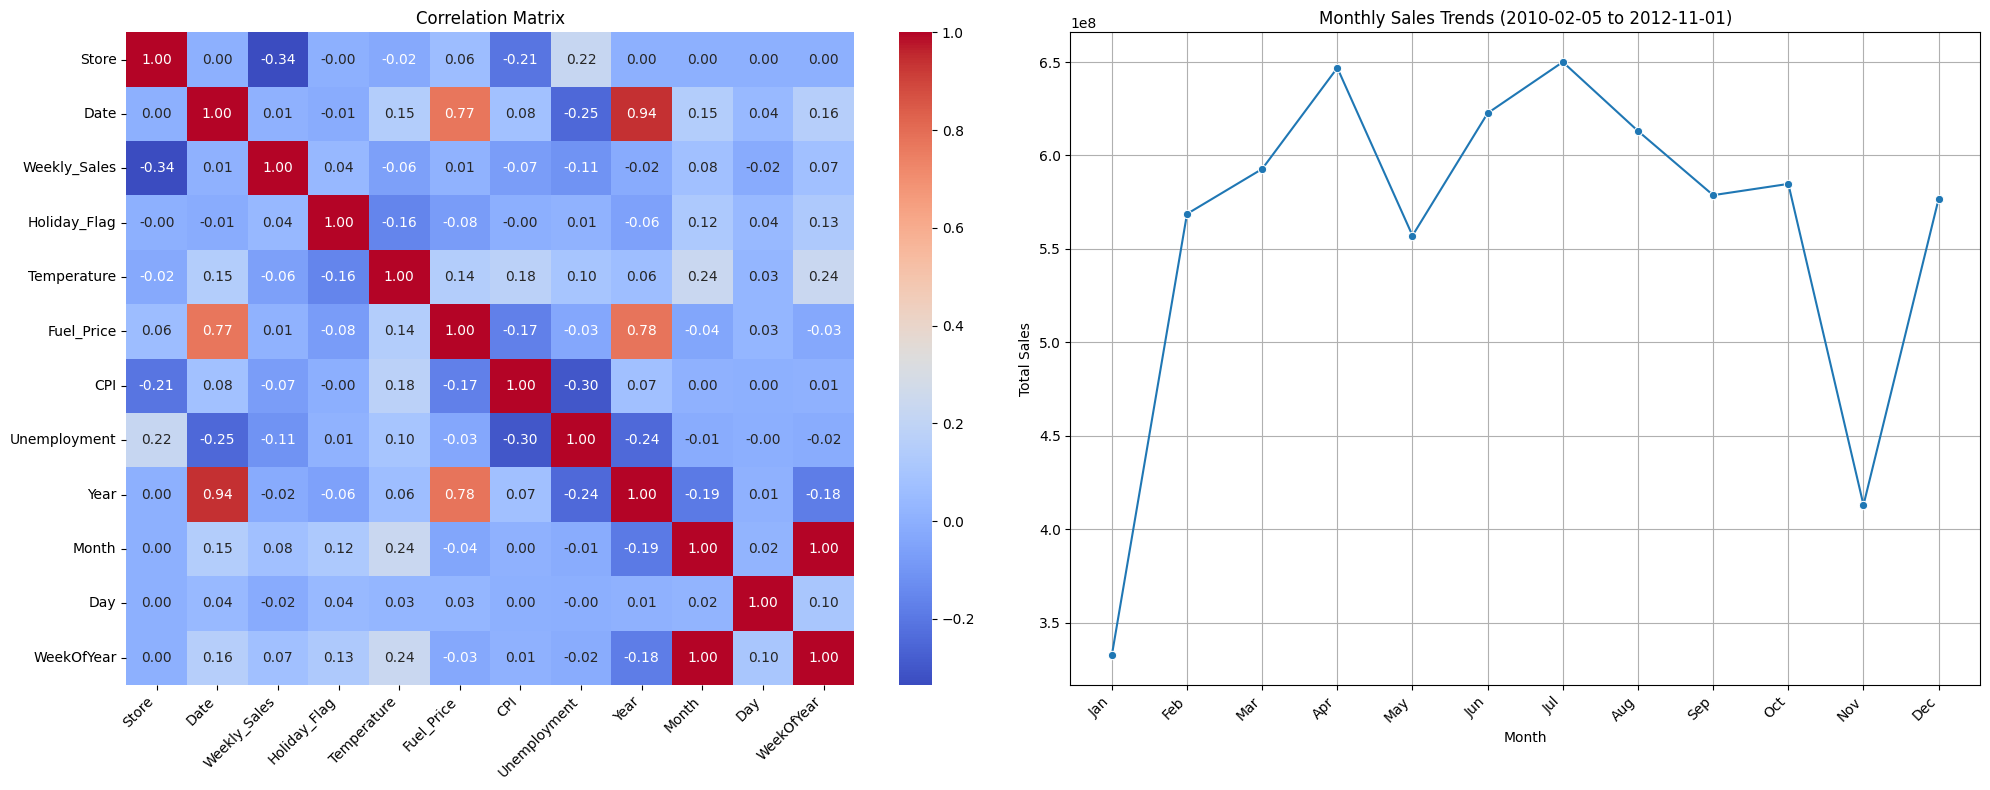

Correlation Summaries:
Fuel_Price and Date: There is a high correlation (0.7714).
Year and Date: There is a high correlation (0.9417).
Year and Fuel_Price: There is a high correlation (0.7795).
WeekOfYear and Month: There is a high correlation (0.9960).

Variance for each numeric column:
Store           1.686929e+02
Weekly_Sales    3.185097e+11
Holiday_Flag    6.504996e-02
Temperature     3.402155e+02
Fuel_Price      2.106991e-01
CPI             1.548951e+03
Unemployment    3.518944e+00
dtype: float64


In [97]:
# Correlation matrix visualization
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))  # Adjust figsize as needed
plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix')

# Monthly sales trends visualization
plt.subplot(1, 2, 2)
monthly_sales = df.groupby('Month')['Weekly_Sales'].sum()
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trends (2010-02-05 to 2012-11-01)')
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# Define thresholds for interpreting correlations
moderate_corr_threshold = 0.5
high_corr_threshold = 0.7

# Function to summarize correlations
def summarize_correlations(corr_matrix):
    print("Correlation Summaries:")
    visited_pairs = set()  # To keep track of visited pairs
    for i, col in enumerate(corr_matrix.columns):
        for j, row in enumerate(corr_matrix.index):
            if i != j:  # Exclude self-correlation (diagonal elements)
                pair = tuple(sorted([row, col]))  # Sort pair to avoid duplicate output
                if pair not in visited_pairs:
                    visited_pairs.add(pair)
                    correlation = corr_matrix.loc[row, col]  # Access correlation value
                    if abs(correlation) >= high_corr_threshold:
                        print(f"{row} and {col}: There is a high correlation ({correlation:.4f}).")
                    elif abs(correlation) >= moderate_corr_threshold:
                        print(f"{row} and {col}: There is a moderate correlation ({correlation:.4f}).")

# Print correlation summaries
summarize_correlations(correlation_matrix)
print()

# Variance
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate variance for each numeric column
variances = df[numeric_cols].var()

# Print or inspect the variances
print("Variance for each numeric column:")
print(variances)

#####**Correlation Summaries at this point:**
---

Fuel_Price and Date: There is a high correlation (0.7714).<br>
Year and Date: There is a high correlation (0.9417).<br>
Year and Fuel_Price: There is a high correlation (0.7795).<br>
WeekOfYear and Month: There is a high correlation (0.9960).<br>
Sales Trends: Peak in April and July. May be seasonal crucial for planning inventory, promotions, staffing during this time.

#####**Variance:**
---

High variance: CPI at 1548.95 suggests significant variability across the dataset and that consumper prices vary widely across time or regions. Weekly_Sales has a high variance showing a possible wie range of sweekly sales and that they may vary from week to week or store to store.

Low variance: Holiday_Flag at .065 reflects little variability and consistent values.

Moderate variance: The remainder show a moderate outcome reflecting varying significance across the dataset.

**Histograms and Plots:**

Holiday_flag (1 and 0), and derived time variables (Year, Month, Day, WeekOfYear).

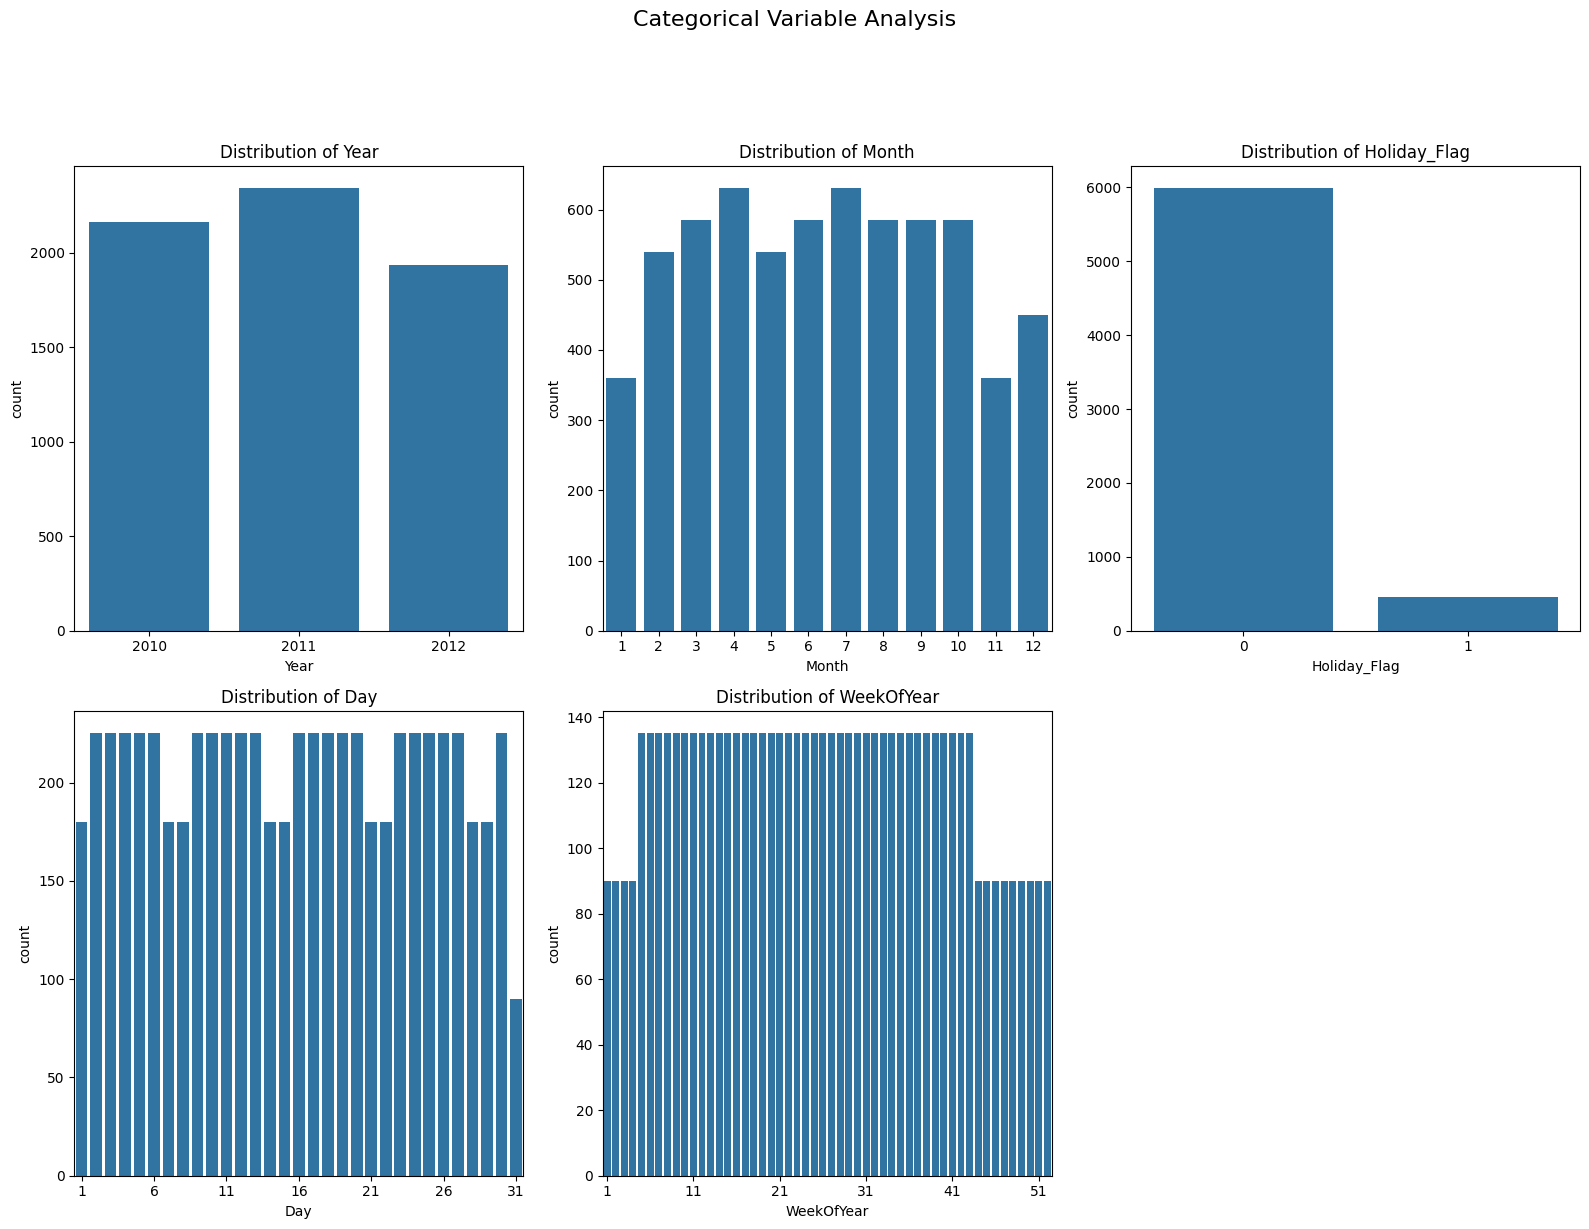

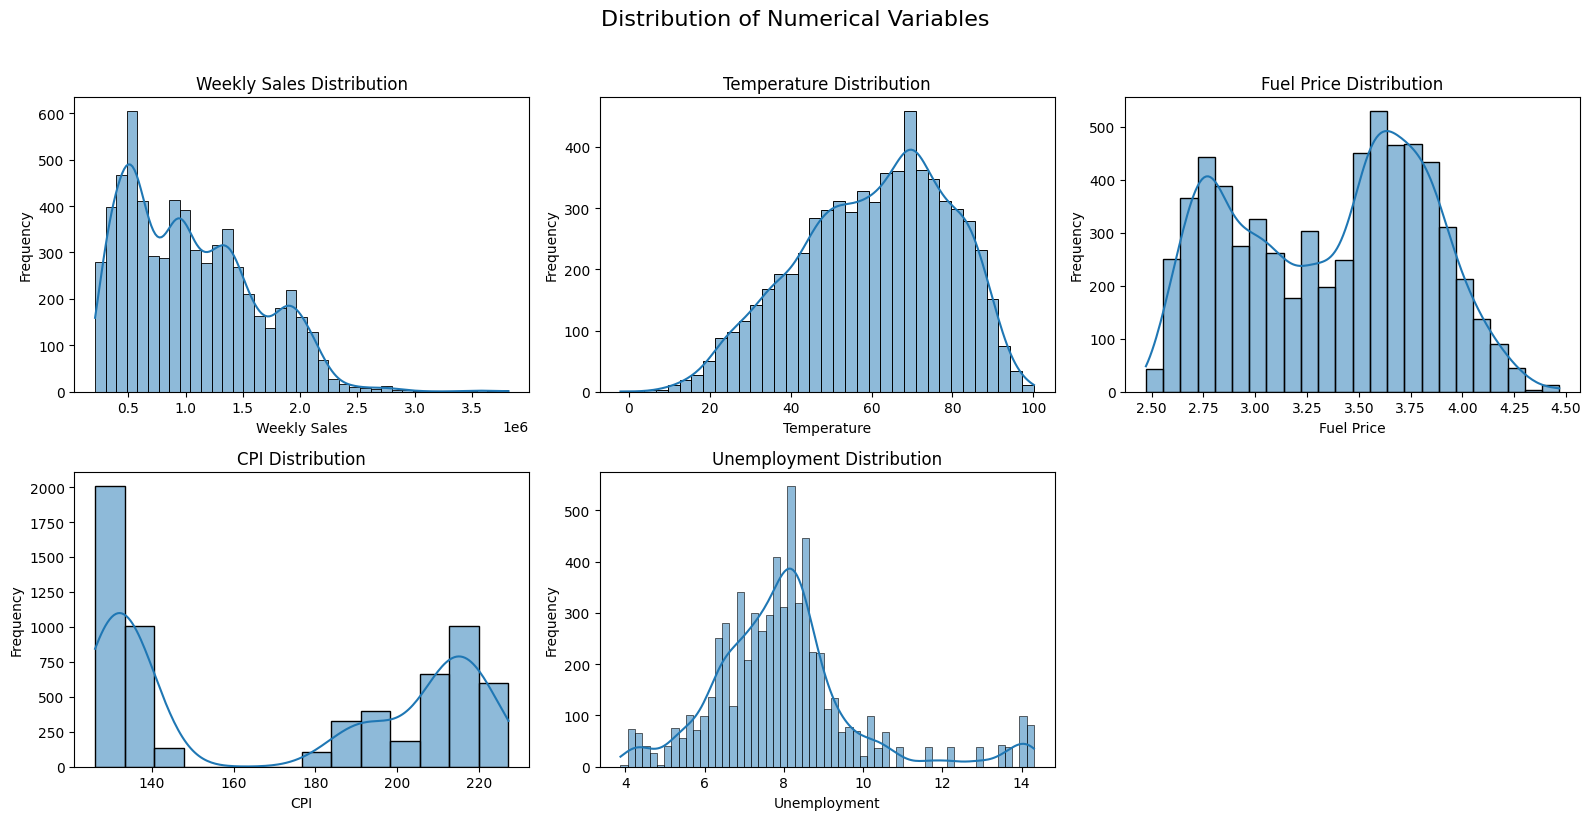

In [98]:
# Categorical Variable Analysis
plt.figure(figsize=(16, 12))  # Adjust overall figure size

# Centered and Larger Title
plt.suptitle('Categorical Variable Analysis', fontsize=16, y=1.02)

# First Line: Distribution of Year, Month, and Holiday_Flag
plt.subplot(2, 3, 1)
sns.countplot(x='Year', data=df)
plt.title('Distribution of Year')

plt.subplot(2, 3, 2)
sns.countplot(x='Month', data=df)
plt.title('Distribution of Month')

plt.subplot(2, 3, 3)
sns.countplot(x='Holiday_Flag', data=df)
plt.title('Distribution of Holiday_Flag')

# Second Line: Distribution of Day and WeekOfYear (reduce xticks or use specific labels)
plt.subplot(2, 3, 4)
sns.countplot(x='Day', data=df)
plt.title('Distribution of Day')
plt.xticks(range(0, 32, 5))  # Show every 5th tick for Day (adjust as needed)

plt.subplot(2, 3, 5)
sns.countplot(x='WeekOfYear', data=df)
plt.title('Distribution of WeekOfYear')
plt.xticks(range(0, 53, 10))  # Show every 10th tick for WeekOfYear (adjust as needed)

# Adjust layout for the first part
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the main title position

# Histograms (combine all in one figure)
plt.figure(figsize=(16, 8))

plt.suptitle('Distribution of Numerical Variables', fontsize=16, y=1.02)  # Title for the second set of plots

plt.subplot(2, 3, 1)
sns.histplot(df['Weekly_Sales'], kde=True)
plt.title('Weekly Sales Distribution')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
sns.histplot(df['Temperature'], kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.subplot(2, 3, 3)
sns.histplot(df['Fuel_Price'], kde=True)
plt.title('Fuel Price Distribution')
plt.xlabel('Fuel Price')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
sns.histplot(df['CPI'], kde=True)
plt.title('CPI Distribution')
plt.xlabel('CPI')
plt.ylabel('Frequency')

plt.subplot(2, 3, 5)
sns.histplot(df['Unemployment'], kde=True)
plt.title('Unemployment Distribution')
plt.xlabel('Unemployment')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()


Insight into dataset's temporal (time), economic and seasonal dynamics:

2011 appears to have more data points and could be due to information gathered covers 2010-02-05 to 2012-11-01. April and July indicates higher peaks. Days 2-6, 10-13, 16-21, 23-27, 30 have higher counts. Weekly sales peak around 0.5 million with a right tail suggesting occasional high sales figures (special events or promotions or outliers). There are more occurrences at lower temperatures in the dataset (lower than 70). Fuel price has two peaks which suggest a possible change in price over time.  CPI has a peak at ~75 and at ~218 showing varying consumer price index levels; it's at 0 around 145-175 suggesting stability. Unemployment peaks at around 9 with lower values surrounding suggesting variation in the rates.

###Feature Selection

In [99]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold

# Separate features and target variable
X = df.drop(['Weekly_Sales', 'Date'], axis=1)  # Drop target variable and Date as it was converted
y = df['Weekly_Sales']

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SelectKBest with f_regression scoring
selector = SelectKBest(score_func=f_regression, k=5)

# Fit selector to training data
X_train_selected = selector.fit_transform(X_train, y_train)

# Get selected feature indices
selected_indices = selector.get_support(indices=True)

# Get feature names
selected_features = X.columns[selected_indices]

# Print selected feature names
print("Selected features from SelectKBest:", selected_features)
print()

# Calculate variance of each feature
variances = df.drop(['Weekly_Sales', 'Date'], axis=1).var()

# Set a threshold for variance
variance_threshold = 1000000  # Adjust the threshold as needed

# Filter features based on variance threshold
selected_features_variance = variances[variances >= variance_threshold].index.tolist()

print("Selected Features based on Variance Threshold:")
print(selected_features_variance)
print()

# Separate features and target variable
X = df.drop(['Weekly_Sales', 'Date'], axis=1)  # Adjust columns as needed
y = df['Weekly_Sales']

# Train a Random Forest model
rf = RandomForestRegressor()
rf.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("Feature Importances from Random Forest:")
print(feature_importances)
print()

# Perform ANOVA F-test
f_values, p_values = f_regression(X, y)

anova_results = pd.DataFrame({'Feature': X.columns, 'F-Value': f_values, 'p-Value': p_values})
anova_results = anova_results.sort_values(by='F-Value', ascending=False)

print("ANOVA F-test Results:")
print(anova_results)
print()

Selected features from SelectKBest: Index(['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear'], dtype='object')

Selected Features based on Variance Threshold:
[]

Feature Importances from Random Forest:
Store           0.671916
CPI             0.149854
Unemployment    0.100126
WeekOfYear      0.043944
Day             0.012563
Temperature     0.010267
Fuel_Price      0.007149
Month           0.002128
Year            0.001341
Holiday_Flag    0.000713
dtype: float64

ANOVA F-test Results:
        Feature     F-Value        p-Value
0         Store  815.022439  6.883078e-169
5  Unemployment   73.348421   1.344837e-17
7         Month   37.514784   9.607839e-10
9    WeekOfYear   35.624738   2.519662e-09
4           CPI   34.118717   5.438293e-09
2   Temperature   26.300448   3.007648e-07
1  Holiday_Flag    8.766881   3.078699e-03
6          Year    2.173377   1.404665e-01
8           Day    1.950365   1.625957e-01
3    Fuel_Price    0.576212   4.478287e-01



Based on the collective selection tests, Store appears crucial for predicting as it's highest rated and highest F-Value 815.02. CPI, Unemployment, Month and WeekOfYear also appear to provide insight to predictive power.

###Data Preparation

In [100]:
# Feature selection results
selected_features = ['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear']

# Identifying the Target
target = 'Weekly_Sales'

# Use only selected features
X = df[selected_features]
y = df[target]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print out to confirm
print("Selected Features:")
print(selected_features)
print()
print(f"Target: {target}")
print()
print("Data Preparation Completed:")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Selected Features:
['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear']

Target: Weekly_Sales

Data Preparation Completed:
Training set size: 5148 samples
Testing set size: 1287 samples


###Algorithms

In [101]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings


# Instantiate the regressors
lin_reg = LinearRegression()
rf_regressor = RandomForestRegressor(random_state=42)
gb_regressor = GradientBoostingRegressor(random_state=42)
svm_regressor = SVR()

# Train and evaluate each model
def train_and_evaluate_regressor(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"{type(model).__name__}:")
    print(f"Train - MAE: {train_mae:.4f}, MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, R^2: {train_r2:.4f}")
    print(f"Test  - MAE: {test_mae:.4f}, MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R^2: {test_r2:.4f}")
    print()

# Train and evaluate each regressor
train_and_evaluate_regressor(lin_reg, X_train, X_test, y_train, y_test)
train_and_evaluate_regressor(rf_regressor, X_train, X_test, y_train, y_test)
train_and_evaluate_regressor(gb_regressor, X_train, X_test, y_train, y_test)
train_and_evaluate_regressor(svm_regressor, X_train, X_test, y_train, y_test)

LinearRegression:
Train - MAE: 428497.5192, MSE: 271679091076.6869, RMSE: 521228.4442, R^2: 0.1444
Test  - MAE: 432116.8811, MSE: 274264941758.9879, RMSE: 523703.1046, R^2: 0.1487

RandomForestRegressor:
Train - MAE: 20683.9146, MSE: 1447149298.2565, RMSE: 38041.4156, R^2: 0.9954
Test  - MAE: 59551.0031, MSE: 12060863786.4475, RMSE: 109821.9640, R^2: 0.9626

GradientBoostingRegressor:
Train - MAE: 119220.2869, MSE: 26280754221.3325, RMSE: 162113.3993, R^2: 0.9172
Test  - MAE: 122609.7539, MSE: 28172931723.1607, RMSE: 167847.9423, R^2: 0.9125

SVR:
Train - MAE: 461877.3187, MSE: 324902989217.9483, RMSE: 570002.6221, R^2: -0.0233
Test  - MAE: 471120.7723, MSE: 331329411084.0113, RMSE: 575612.2055, R^2: -0.0285




| Metric Name | Train Value | Test Value | Notes | Interpretation |
|-------------|-------------|------------|-------|----------------|
| **LinearRegression** |||||
| MAE | 428,497.52 | 432,116.88 | Average prediction error | Weak predictive performance. High errors and low R². Not recommended. |
| MSE | 271,679,091,076.69 | 274,264,941,758.99 | Average squared prediction error | Weak predictive performance. High errors and low R². Not recommended. |
| RMSE | 521,228.44 | 523,703.10 | Root of average squared prediction error | Weak predictive performance. High errors and low R². Not recommended. |
| R² | 0.1444 | 0.1487 | Variance explained by model | Weak predictive performance. High errors and low R². Not recommended. |

| Metric Name | Train Value | Test Value | Notes | Interpretation |
|-------------|-------------|------------|-------|----------------|
|-------------|-------------|------------|-------|----------------|
| **RandomForestRegressor** |||||
| MAE | 20,683.91 | 59,551.00 | Average prediction error | Strong performance. Low errors and high R². Recommended. |
| MSE | 1,447,149,298.26 | 12,060,863,786.45 | Average squared prediction error | Strong performance. Low errors and high R². Recommended. |
| RMSE | 38,041.42 | 109,821.96 | Root of average squared prediction error | Strong performance. Low errors and high R². Recommended. |
| R² | 0.9954 | 0.9626 | Variance explained by model | Strong performance. Low errors and high R². Recommended. |

| Metric Name | Train Value | Test Value | Notes | Interpretation |
|-------------|-------------|------------|-------|----------------|
| **GradientBoostingRegressor** |||||
| MAE | 119,220.29 | 122,609.75 | Average prediction error | Good performance. Low errors and high R². Recommended. |
| MSE | 26,280,754,221.33 | 28,172,931,723.16 | Average squared prediction error | Good performance. Low errors and high R². Recommended. |
| RMSE | 162,113.40 | 167,847.94 | Root of average squared prediction error | Good performance. Low errors and high R². Recommended. |
| R² | 0.9172 | 0.9125 | Variance explained by model | Good performance. Low errors and high R². Recommended. |

| Metric Name | Train Value | Test Value | Notes | Interpretation |
|-------------|-------------|------------|-------|----------------|
| **SVR** |||||
| MAE | 461,877.32 | 471,120.77 | Average prediction error | Poor performance. High errors and negative R². Not recommended. |
| MSE | 324,902,989,217.95 | 331,329,411,084.01 | Average squared prediction error | Poor performance. High errors and negative R². Not recommended. |
| RMSE | 570,002.62 | 575,612.21 | Root of average squared prediction error | Poor performance. High errors and negative R². Not recommended. |
| R² | -0.0233 | -0.0285 | Variance explained by model | Poor performance. High errors and negative R². Not recommended. |

Conclusion: We will proceed with RandomForestRegressor and GradientBoostingRegressor.


###Hyperparameter Tuning

RandomForestRegressor using RandomizedSearchCV

In [102]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define the parameter grid with reduced ranges
param_dist = {
    'n_estimators': randint(50, 150),
    'max_depth': [None, 10, 20],
    'min_samples_split': randint(2, 8),
    'min_samples_leaf': randint(1, 4),
    'bootstrap': [True, False]
}

# Instantiate the model
rf = RandomForestRegressor(random_state=42)

# Instantiate the RandomizedSearchCV object with reduced n_iter and cv
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                   n_iter=50, cv=2, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {-random_search.best_score_}")


Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 127}
Best Score: 64915.77955647178


This is not a good model as our predictions would be off by 64,915.77.

GradientBoostingRegressor using RandomizedSearchCV

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import randint, uniform

# Define the parameter grid with reduced ranges
param_dist = {
    'n_estimators': randint(50, 150),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': randint(2, 8),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Instantiate the model
gbr = GradientBoostingRegressor(random_state=42)

# Instantiate the RandomizedSearchCV object with reduced n_iter and cv
random_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_dist,
                                   n_iter=50, cv=2, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error', random_state=42)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {-random_search.best_score_}")


Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best Parameters: {'learning_rate': 0.18726788295647254, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 116}
Best Score: 53921.36091531413


This model fits better with predictions being off by 53,921

**Evaluate the model**

In [104]:
# Extract the best model from RandomizedSearchCV
best_gbr = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_gbr.predict(X_test)

# Calculate MAE, MSE, RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Calculate RMSE from MSE

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Print out the metrics
print(f"Metrics for GradientBoostingRegressor:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Metrics for GradientBoostingRegressor:
MAE: 47121.3911
MSE: 6681388736.7212
RMSE: 81739.7623
R²: 0.9793


Model predictions would be around 47,121 units off from the true values. The MSE of 6681388736 shows we are way off target. If predictions were made on this model, (RMSE) we would be off by $81,739.

Despite this, the R squared is at 0.9793 which means it can explain 97.3% of what is happening with sales (the closer R squared is to 1, the better the model is at predicting accurately). This R square is very, very good.



Lets try to predict

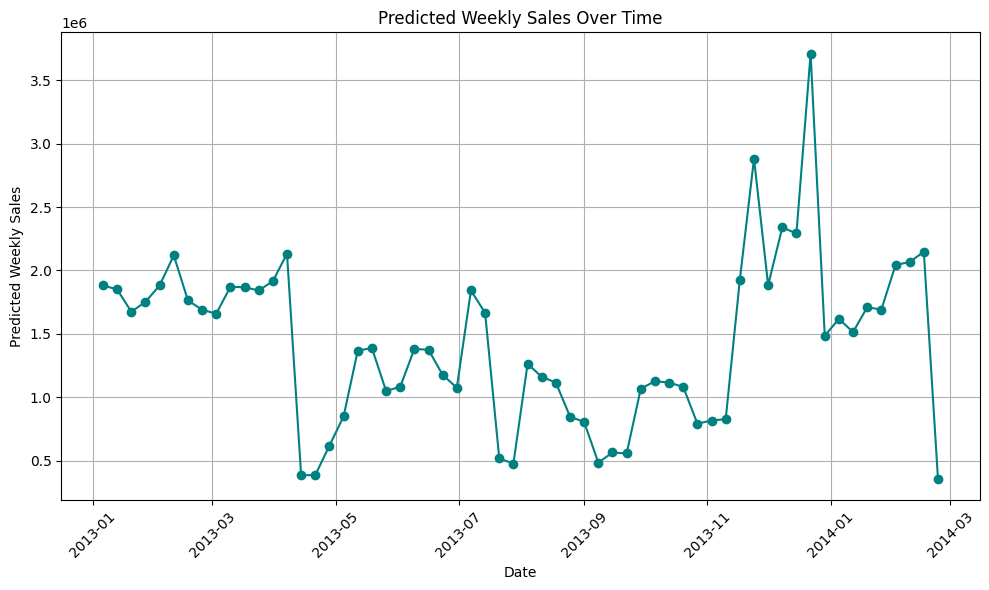

In [121]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

# Define features used in training
selected_features = ['Store', 'CPI', 'Unemployment', 'Month', 'WeekOfYear']

# Define average values for economic indicators for future predictions
average_cpi = df['CPI'].mean()
average_unemployment = df['Unemployment'].mean()
average_month = df['Month'].mean()
average_week_of_year = df['WeekOfYear'].mean()

# Define the start date for future predictions
start_date = pd.Timestamp('2013-01-01')

# Generate future dates for 3-5 years
future_dates = pd.date_range(start=start_date, periods=60, freq='W')

# Create future_data DataFrame
future_data = pd.DataFrame({
    'Date': future_dates,
    'Store': np.tile(np.arange(1, 46), len(future_dates) // 45 + 1)[:len(future_dates)],  # Repeat store numbers for future dates
    'CPI': np.tile(average_cpi, len(future_dates)),
    'Unemployment': np.tile(average_unemployment, len(future_dates)),
    'Month': future_dates.month,
    'WeekOfYear': future_dates.isocalendar().week
})

# Predict weekly sales for future_data using the best model
predicted_sales = best_gbr.predict(future_data[selected_features])

# Add predicted sales to future_data DataFrame
future_data['Predicted_Weekly_Sales'] = predicted_sales

# Optional: Plot predicted weekly sales over time
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(future_data['Date'], future_data['Predicted_Weekly_Sales'], color='teal', marker='o', linestyle='-')
plt.title('Predicted Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Predicted Weekly Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###Conclusion Redo tomorrow for Walmart project

## Summary of Findings

- **Dataset Overview:**
  - The dataset comprises 299 patients with 13 clinical variables, including demographic factors, clinical measurements, and health conditions.

- **Key Insights:**
  - **Demographics and Health Conditions:** The dataset predominantly includes adult male patients (64.88%), with significant proportions affected by anaemia (43%), diabetes (42%), and high blood pressure (35%).
  - **Clinical Measurements:** Notable averages include ejection fraction (mean ~38.08%), serum creatinine (mean ~1.39 mg/dL), serum sodium (mean ~136.63 mEq/L), and platelet count (mean ~263,358 kiloplatelets/mL), indicating variability across patients.
  - **Follow-up Period:** Patients were monitored for an average of ~130.26 days, offering insights into the duration of study follow-up.

- **Feature Importance:**
  - Through various feature selection methods, including ANOVA F-test, Random Forest feature importance, and Recursive Feature Elimination (RFE), the following features were consistently identified as predictive of heart failure: 'age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', and 'time'.

## Model Evaluation and Selection

- **Model Performance:**
  - **Tuned Logistic Regression:** Achieved an accuracy of 78.33% with a precision of 81.81%, recall of 78.33%, and F1 score of 76.75%, demonstrating balanced performance across metrics.
  - **Tuned Gradient Boosting Classifier:** Showed the lowest metrics amongst the models.
  - **Tuned Random Forest Classifier:** Demonstrated robust performance with decent accuracy and F1 score, albeit slightly lower precision compared to Logistic Regression.

- **Model Selection Rationale:**
  - Logistic Regression was selected as the most suitable model due to its balanced performance across all evaluation metrics and its interpretability in clinical settings.

## Clinical Implications and Recommendations

- **Clinical Insights:**
  - The identified predictors can aid healthcare providers in prioritizing interventions and monitoring strategies for patients at higher risk of heart failure.
  - Examples of practical applications include personalized treatment plans based on patient demographics and clinical measurements.

## Limitations and Future Directions

- **Study Limitations:**
  - Potential limitations include the dataset's size and scope, as well as assumptions made during model training.
  - Further validation in diverse patient populations and incorporation of additional clinical variables could enhance model robustness.

- **Future Research Directions:**
  - Future studies could consider exploring additional advanced machine learning techniques or ensemble methods to further enhance predictive accuracy and generalize findings beyond the scope of this project.
  - Research focusing on real-time predictive modeling and integration with electronic health records could further enhance clinical decision support systems.
